# 4 - Telco Customer Churn: Neural Network
## Predictive Neural Network
### Alden Chico

---

## Premise

---

## Import Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Import the Telco churn dataset with selected OHE features from CSV file
data = pd.read_csv('output/2-EDA/clean_telco.csv')
data = data.drop(['Unnamed: 0', 'customerID'], axis=1)

In [3]:
# Save all the predictors/target columns as numpy arrays for Keras
y = data['churn']
predictors = data.drop(['churn'], axis=1).values
n_cols = predictors.shape[1]

print(f'No. of columns in selected OHE column Dataset: {n_cols}')

No. of columns in selected OHE column Dataset: 13


---

## Create Helper Functions to Create Neural Network

In [4]:
# Baseline neural network layer
from keras.layers import Dense
from keras.models import Sequential
def create_baseline_model(n_units, n_cols):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(n_cols, )))
    return model

Using TensorFlow backend.


In [5]:
# Adds fully connected layers with specified amount of neurons
def add_model_layers(model, neuron_list):
    for neuron in neuron_list:
        model.add(Dense(neuron, activation='relu'))

In [6]:
# Adds the final model layer and compiles
def finish_model(model):
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# Activates output to prediction since sigmoid output is between 0 and 1
def activate_output(y_pred):
    activ_y = []
    for y in y_pred:
        if y < 0.5:
            activ_y.append(0)
        else:
            activ_y.append(1)
    return activ_y

---

## Results Function

In [8]:
# Function that plots confusion matrix / classification report after making predictions
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_results(y_test, y_pred, output_dict=False):
    cr = classification_report(y_test, y_pred, output_dict=output_dict)
    # Display results if plot_results doesn't want to return classification report
    if output_dict == False:
        conf_mat = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(conf_mat, index = ['Did Not Churn', 'Churn'],
                          columns = ['Did Not Churn', 'Churn'])
        _ = sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
        _ = plt.title('Churn Confusion Matrix', fontsize=20)
        _ = plt.ylabel('True', fontsize=14)
        _ = plt.xlabel('Predicted', fontsize=14)
        _ = plt.show()
        print(cr)
    # Only return classification report if desire dictionary results
    return cr

---

## Create and Plot F1-Scores for User Churn to Evaluate Model

In [9]:
f1_dict_all = {}
acc_dict_all = {}

f1_dict_clea = {}
acc_dict_clean = {}

In [10]:
# Plot the change in F1-scores over the different NN models
def plot_f1_acc(f1_dict, acc_dict, f1_dict_clean, acc_dict_clean):
    
    fig, axs = plt.subplots(2, 2, figsize=(20,10))
    
    # Gather f1_dict values and keys from all dataset
    list_val = list(f1_dict.values())
    list_keys = list(f1_dict.keys())
    avg_f1_score = np.mean(list_val)
    
    # Gather acc_dict values and keys from all dataset
    list_acc = list(acc_dict.values())
    list_acc_keys = list(acc_dict.keys())
    avg_acc_score = np.mean(list_acc)
    
    # Gather f1_dict values and keys from all dataset
    list_val_clean = list(f1_dict_clean.values())
    list_keys_clean = list(f1_dict_clean.keys())
    avg_f1_score_clean = np.mean(list_val_clean)
    
    # Gather acc_dict values and keys from all dataset
    list_acc_clean = list(acc_dict_clean.values())
    list_acc_keys_clean = list(acc_dict_clean.keys())
    avg_acc_score_clean = np.mean(list_acc_clean)
    
    # Plot F1 Scores for All Dataset
    _ = axs[0][0].plot(list_val, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Churn Prediction F1-Score')
    _ = axs[0][0].axhline(avg_f1_score, color='red', linestyle='dashed', label=f'Average F1-Score : {avg_f1_score:.2f}')
    _ = axs[0][0].set_title('F1-Score for Models on Non-Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[0][0].set_xticks(range(len(list_val)))
    _ = axs[0][0].set_xticklabels(list_keys, rotation=60)
    _ = axs[0][0].set_xlabel('Model Description')
    _ = axs[0][0].set_ylabel('F1-Score')
    _ = axs[0][0].legend(loc='lower right')
    
    
    # Plot Accuracy Scores for All Dataset
    _ = axs[0][1].plot(list_acc, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Accuracy')
    _ = axs[0][1].axhline(avg_acc_score, color='red', linestyle='dashed', label=f'Average Accuracy : {avg_acc_score:.2f}')
    _ = axs[0][1].set_title('Accuracy for Models on Non-Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[0][1].set_xticks(range(len(list_acc)))
    _ = axs[0][1].set_xticklabels(list_acc_keys, rotation=60)
    _ = axs[0][1].set_xlabel('Model Description')
    _ = axs[0][1].set_ylabel('Accuracy')
    _ = axs[0][1].legend(loc='lower right')
    
    # Plot F1 Scores for Clean Dataset
    _ = axs[1][0].plot(list_val_clean, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Churn Prediction F1-Score')
    _ = axs[1][0].axhline(avg_f1_score_clean, color='red', linestyle='dashed', 
                          label=f'Average F1-Score : {avg_f1_score_clean:.2f}')
    _ = axs[1][0].set_title('F1-Score for Models on Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[1][0].set_xticks(range(len(list_val_clean)))
    _ = axs[1][0].set_xticklabels(list_keys_clean, rotation=60)
    _ = axs[1][0].set_xlabel('Model Description')
    _ = axs[1][0].set_ylabel('F1-Score')
    _ = axs[1][0].legend(loc='lower right')
    
    
    # Plot Accuracy Scores for Clean Dataset
    _ = axs[1][1].plot(list_acc_clean, marker='o', color='black', linestyle='solid', 
                 linewidth='2', label='Accuracy')
    _ = axs[1][1].axhline(avg_acc_score_clean, color='red', linestyle='dashed', 
                          label=f'Average Accuracy : {avg_acc_score_clean:.2f}')
    _ = axs[1][1].set_title('Accuracy for Models on Selected Variable Dataset', fontsize=14, fontweight='bold')
    _ = axs[1][1].set_xticks(range(len(list_acc_clean)))
    _ = axs[1][1].set_xticklabels(list_acc_keys_clean, rotation=60)
    _ = axs[1][1].set_xlabel('Model Description')
    _ = axs[1][1].set_ylabel('Accuracy')
    _ = axs[1][1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

---

## Evaluate and Test Baseline Model

In [11]:
# Stratify training and testing data according to distribution of total sample
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(predictors, y):
    X_train, X_test = np.array(predictors[train_index]), np.array(predictors[test_index])
    y_train, y_test = np.array(y[train_index]), np.array(y[test_index])

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5634, 13) (1409, 13) (5634,) (1409,)


In [12]:
# Performs 3-Fold CV on baseline model
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores=[]
for train, test in kfold.split(X_train, y_train):
    # Model Architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = finish_model(model)
    
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=10, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Accuracy: 77.82%
Accuracy: 45.16%
Accuracy: 57.76%
Accuracy: 79.86%
Accuracy: 78.95%
67.91% (+/- 14.02%)


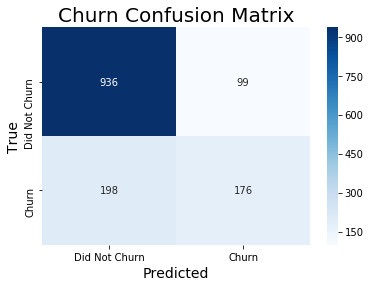

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [13]:
# Train on all training data and predict on hold-out set

# Fit baseline model to all training data
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
_ = plot_results(y_test, y_pred_base)
cr_base = plot_results(y_test, y_pred_base, output_dict=True)

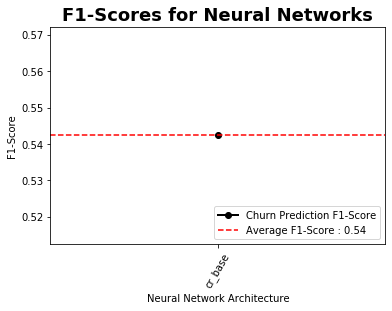

<Figure size 1080x360 with 0 Axes>

In [14]:
# Plot base model
f1_dict['cr_base'] = cr_base['1']['f1-score']
_ = plot_f1(f1_dict)

---

## Making a Deeper Model

In [15]:
# Performs 3-Fold CV on 1 hidden layer model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [n_cols]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=10, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy: 73.56%
Accuracy: 71.43%
Accuracy: 78.62%
Accuracy: 76.75%
Accuracy: 75.22%
75.12% (+/- 2.49%)


In [16]:
# Plot accuracy and variance through various sizes of single layer model
def plot_variance_single_layer(X_train, y_train, neuron_list):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    acc_list = []
    std_list = []
    # Add a layer with n_cols number of neurons
    for neuron in neuron_list:
        cv_scores=[]
        for train, test in kfold.split(X_train, y_train):
            # Model architecture
            model = create_baseline_model(n_units=X_train.shape[1], n_cols=X_train.shape[1])
            n_in = [neuron]
            _ = add_model_layers(model, n_in)
            _ = finish_model(model)

            # Model Evaluation
            model.fit(X_train[train], y_train[train], epochs=10, batch_size=10, verbose=False)
            scores = model.evaluate(X_train[test], y_train[test], verbose=False)
            cv_scores.append(scores[1] * 100)
        
    # Average model performance
        acc_list.append(np.mean(cv_scores))
        std_list.append(np.std(cv_scores))

    # Plot variance
    fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True)

    _ = axs[0].bar(neuron_list, acc_list)
    _ = axs[0].set_title('Accuracy w. Varying Number of Neurons')
    _ = axs[0].set_xlabel('1st Hidden Layer Neuron Count')
    _ = axs[0].set_ylabel('Accuracy')

    _ = axs[1].bar(neuron_list, std_list)
    _ = axs[1].set_title('Variance w. Varying Number of Neurons')
    _ = axs[1].set_title('Variance')
    _ = axs[1].set_xlabel('1st Hidden Layer Neuron Count')
    _ = axs[1].set_ylabel('Variance')
    
    _ = fig.suptitle('Accuracy and Variance w. Varying Neuron Count', y=1.03, fontsize=20)

    plt.show()

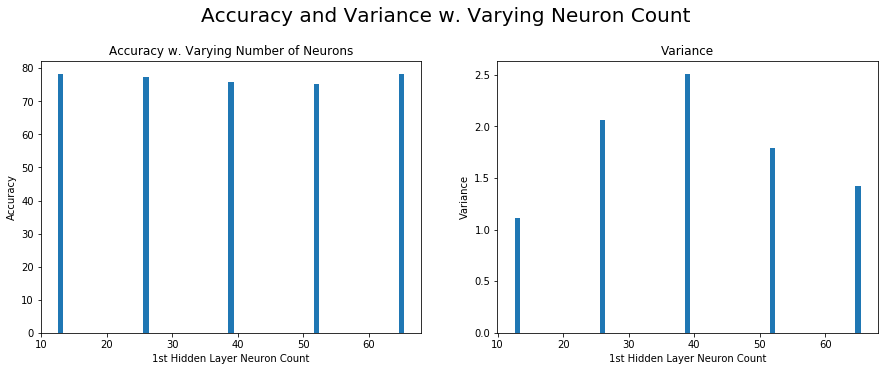

In [17]:
neuron_list = [x*n_cols for x in range(1, 6)]
_ = plot_variance_single_layer(X_train, y_train, neuron_list)

---

## Using More Hidden Layers

In [18]:
# Performs 3-Fold CV on 3 hidden layer model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [n_cols, n_cols, n_cols]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=10, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy: 77.55%
Accuracy: 78.62%
Accuracy: 79.15%
Accuracy: 77.99%
Accuracy: 78.42%
78.35% (+/- 0.54%)


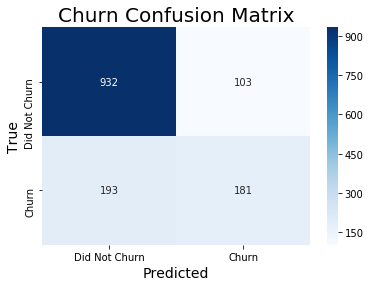

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [19]:
# Train on all training data and predict on hold-out set

# Fit 3-layer model to all training data
neurons = [n_cols, n_cols, n_cols]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
_ = plot_results(y_test, y_pred_base)
cr_3_layers = plot_results(y_test, y_pred_base, output_dict=True)

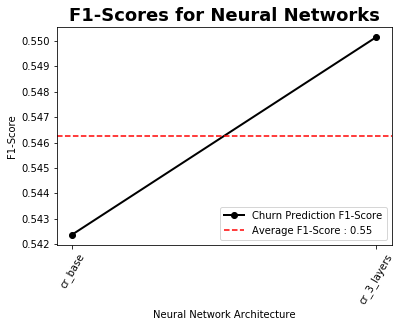

<Figure size 1080x360 with 0 Axes>

In [20]:
# Add 3-layer model to F1 plot
f1_dict['cr_3_layers'] = cr_3_layers['1']['f1-score']
_ = plot_f1(f1_dict)

---

## Decreasing Batch Size

In [21]:
# Performs 3-Fold CV on 3 hidden layer model with batch size = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [n_cols, n_cols, n_cols]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy: 76.04%
Accuracy: 79.33%
Accuracy: 74.89%
Accuracy: 79.24%
Accuracy: 78.15%
77.53% (+/- 1.77%)


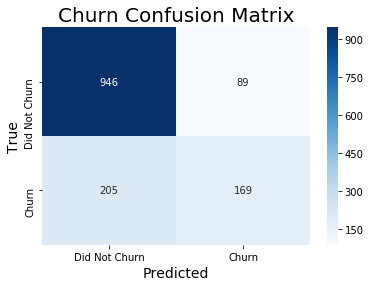

              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1035
           1       0.66      0.45      0.53       374

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [22]:
# Train on all training data and predict on hold-out set

# Fit smaller batch-size model to all training data
neurons = [n_cols, n_cols, n_cols]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
_ = plot_results(y_test, y_pred_base)
cr_small_batch = plot_results(y_test, y_pred_base, output_dict=True)

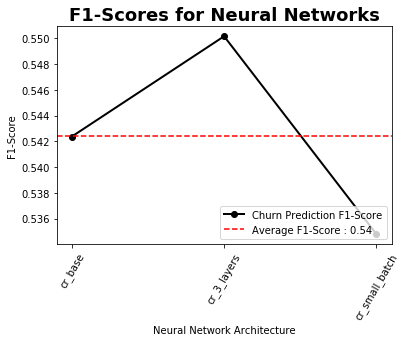

<Figure size 1080x360 with 0 Axes>

In [23]:
# Add smaller batch size F1-score to plot
f1_dict['cr_small_batch'] = cr_small_batch['1']['f1-score']
_ = plot_f1(f1_dict)

---

## Adjusting Hidden Layer Widths

### Hidden Layer Width - 20 Neurons / Layer

In [24]:
# Performs 3-Fold CV on 3 hidden layer model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [20, 20, 20]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy: 75.78%
Accuracy: 77.82%
Accuracy: 78.53%
Accuracy: 80.04%
Accuracy: 80.02%
78.43% (+/- 1.58%)


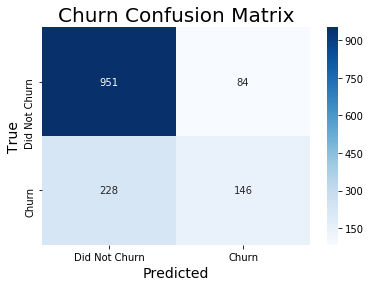

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1035
           1       0.63      0.39      0.48       374

    accuracy                           0.78      1409
   macro avg       0.72      0.65      0.67      1409
weighted avg       0.76      0.78      0.76      1409



In [25]:
# Train on all training data and predict on hold-out set

# Fit all training data to 20 neuron/layer model
neurons = [20, 20, 20]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
_ = plot_results(y_test, y_pred_base)
cr_20_n = plot_results(y_test, y_pred_base, output_dict=True)

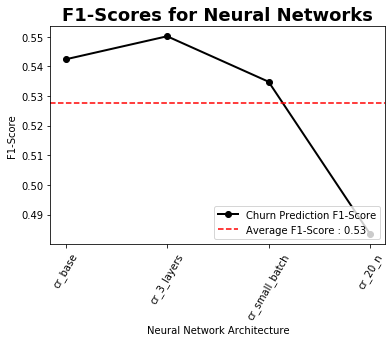

<Figure size 1080x360 with 0 Axes>

In [26]:
f1_dict['cr_20_n'] = cr_20_n['1']['f1-score']
_ = plot_f1(f1_dict)

### Hidden Layer Width - 50 Neurons / Layer

In [27]:
# Performs 3-Fold CV on 3 hidden layer model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [50, 50, 50]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy: 77.37%
Accuracy: 79.86%
Accuracy: 78.44%
Accuracy: 78.79%
Accuracy: 75.93%
78.08% (+/- 1.33%)


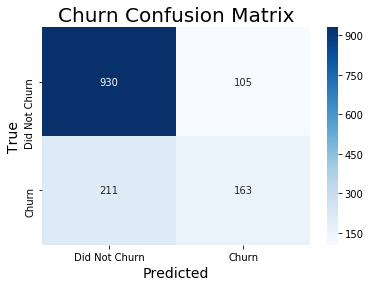

              precision    recall  f1-score   support

           0       0.82      0.90      0.85      1035
           1       0.61      0.44      0.51       374

    accuracy                           0.78      1409
   macro avg       0.71      0.67      0.68      1409
weighted avg       0.76      0.78      0.76      1409



In [28]:
# Train on all training data and predict on hold-out set

# Fit all training data to 50 neuron/layer model
neurons = [50, 50, 50]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
_ = plot_results(y_test, y_pred_base)
cr_50_n = plot_results(y_test, y_pred_base, output_dict=True)

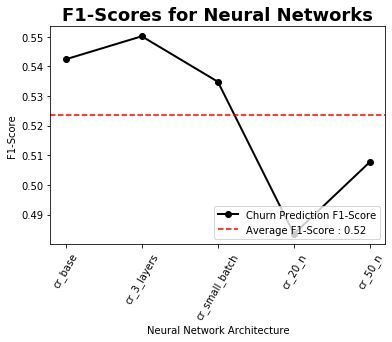

<Figure size 1080x360 with 0 Axes>

In [29]:
f1_dict['cr_50_n'] = cr_50_n['1']['f1-score']
_ = plot_f1(f1_dict)

### Hidden Layer Width - 100 Neurons / Layer

In [30]:
# Performs 3-Fold CV on 3 hidden layer model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [100, 100, 100]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy: 78.17%
Accuracy: 78.44%
Accuracy: 77.91%
Accuracy: 77.02%
Accuracy: 75.49%
77.40% (+/- 1.07%)


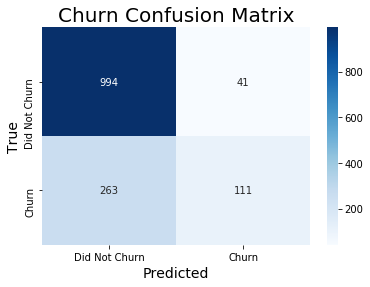

              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1035
           1       0.73      0.30      0.42       374

    accuracy                           0.78      1409
   macro avg       0.76      0.63      0.64      1409
weighted avg       0.77      0.78      0.75      1409



In [31]:
# Train on all training data and predict on hold-out set

# Fit all training data to 100 neuron/layer model
neurons = [100, 100, 100]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
_ = plot_results(y_test, y_pred_base)
cr_100_n = plot_results(y_test, y_pred_base, output_dict=True)

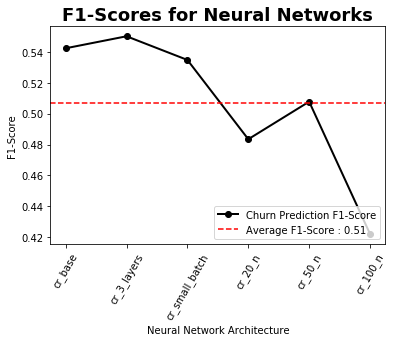

<Figure size 1080x360 with 0 Axes>

In [32]:
f1_dict['cr_100_n'] = cr_100_n['1']['f1-score']
_ = plot_f1(f1_dict)

---

## Adding More Hidden Layers

### 5 Hidden Layers, 20 Neurons/Layer

In [33]:
# Performs 3-Fold CV on 3 hidden layer model
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores= []

# Add a layer with n_cols number of neurons
neurons = [20, 20, 20, 20, 20]
for train, test in kfold.split(X_train, y_train):
    # Model architecture
    model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
    _ = add_model_layers(model, neurons)
    _ = finish_model(model)
    
    # Model Evaluation
    model.fit(X_train[train], y_train[train], epochs=10, batch_size=5, verbose=False)
    scores = model.evaluate(X_train[test], y_train[test], verbose=False)
    print(f"Accuracy: {scores[1]*100:.2f}%")
    cv_scores.append(scores[1] * 100)
    
# Average model performance
print(f"{np.mean(cv_scores):.2f}% (+/- {np.std(cv_scores):.2f}%)")

Accuracy: 76.49%
Accuracy: 79.06%
Accuracy: 78.62%
Accuracy: 75.60%
Accuracy: 79.57%
77.87% (+/- 1.55%)


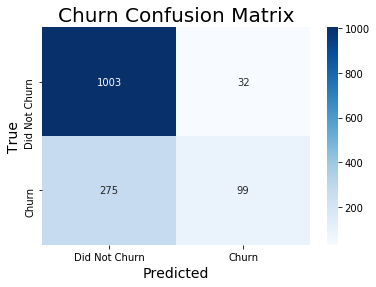

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      1035
           1       0.76      0.26      0.39       374

    accuracy                           0.78      1409
   macro avg       0.77      0.62      0.63      1409
weighted avg       0.78      0.78      0.74      1409



In [34]:
# Train on all training data and predict on hold-out set

# Fit all training data to 20 neuron/layer model
neurons = [20, 20, 20, 20, 20]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
_ = plot_results(y_test, y_pred_base)
cr_20n_5l = plot_results(y_test, y_pred_base, output_dict=True)

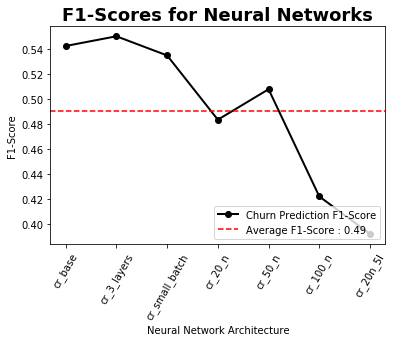

<Figure size 1080x360 with 0 Axes>

In [35]:
f1_dict['cr_20n_5l'] = cr_20n_5l['1']['f1-score']
_ = plot_f1(f1_dict)

---

## Train on More Churn Data

In [36]:
total_churn = y.loc[y == 0].shape[0]
total_no_churn = y.loc[y == 1].shape[0]
print(f'No. of rows with people that churned: {total_churn}')
print(f'No. of rows with people that didn\'t churn: {total_no_churn}')

No. of rows with people that churned: 5174
No. of rows with people that didn't churn: 1869


In [37]:
# Function that trains data by desired number of churn/non-churn values and returns train-test splits
def custom_churn_stratify(X, y, num_churn, no_churn):
    # Gather separate churn index lists
    churn_ind_list = list(y.loc[y==1].index)
    no_churn_ind_list = list(y.loc[y==0].index)
    total_num = len(y)
    if len(churn_ind_list) < num_churn:
        print('Not enough data')
        return None, None, None, None
    
    # Generate train-test split on churn data
    X_train_churn, X_test_churn = X[churn_ind_list[:num_churn]], X[churn_ind_list[num_churn:]]
    y_train_churn, y_test_churn = y[churn_ind_list[:num_churn]], y[churn_ind_list[num_churn:]]
    y_train_churn = np.expand_dims(y_train_churn, axis=1)
    y_test_churn = np.expand_dims(y_test_churn, axis=1)
    
    # Generate train-test split on non-churn data
    X_train_no_churn, X_test_no_churn = X[no_churn_ind_list[:no_churn]], X[no_churn_ind_list[no_churn:]]
    y_train_no_churn, y_test_no_churn = y[no_churn_ind_list[:no_churn]], y[no_churn_ind_list[no_churn:]]
    y_train_no_churn = np.expand_dims(y_train_no_churn, axis=1)
    y_test_no_churn = np.expand_dims(y_test_no_churn, axis=1)
        
    n_cols = X_train_churn.shape[1]
    # Combine churn/non-churn train splits
    X_train = np.append(X_train_churn, X_train_no_churn, axis=0)
    y_train = np.append(y_train_churn, y_train_no_churn, axis=0)
    # Concatenate the features/target and shuffle rows
    X_y_train = np.concatenate((X_train, y_train), axis=1)
    np.random.shuffle(X_y_train)
    X_train = X_y_train[:, :n_cols]
    y_train = X_y_train[:, n_cols]
    
    # Combine churn/non-churn test splits
    X_test = np.append(X_test_churn, X_test_no_churn, axis=0)
    y_test = np.append(y_test_churn, y_test_no_churn, axis=0)
    # Concatenate the features/target and shuffle rows
    X_y_test = np.concatenate((X_test, y_test), axis=1)
    np.random.shuffle(X_y_test)
    X_test = X_y_test[:, :n_cols]
    y_test = X_y_test[:, n_cols]
    
    return X_train, X_test, y_train, y_test

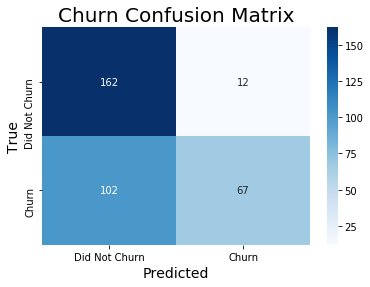

              precision    recall  f1-score   support

         0.0       0.61      0.93      0.74       174
         1.0       0.85      0.40      0.54       169

    accuracy                           0.67       343
   macro avg       0.73      0.66      0.64       343
weighted avg       0.73      0.67      0.64       343



In [38]:
# Train on all training data and predict on hold-out set
X_train, X_test, y_train, y_test = custom_churn_stratify(predictors, y, num_churn=1700, no_churn=5000)

# Fit all training data to 20 neuron/layer model
neurons = [20, 20, 20]
model = create_baseline_model(n_units=n_cols, n_cols=n_cols)
_ = add_model_layers(model, neurons)
_ = finish_model(model)
model.fit(X_train, y_train, epochs=10, batch_size=5, verbose=False)

# Make predictions on testing data and print classification report
y_pred_base = activate_output(model.predict(X_test))
_ = plot_results(y_test, y_pred_base)
cr_20n_c_strat = plot_results(y_test, y_pred_base, output_dict=True)

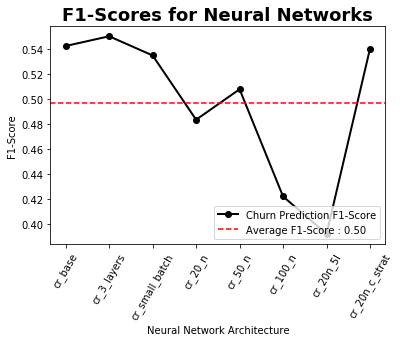

<Figure size 1080x360 with 0 Axes>

In [39]:
f1_dict['cr_20n_c_strat'] = cr_20n_c_strat['1.0']['f1-score']
_ = plot_f1(f1_dict)

Problem doesn't have the complexity to warrant the use of a neural network
Not surprising that logistic regression performed best
    Must build baseline problems first
    Understand that logistic regression is okay
        LR assumes independence between all variables
    Structure of data isn't complex, the data columns are independent of one another
    How much better is logistic regression?
        If LR is nominally better than other models, best to use more complex models
        More complex models work better on more data
    Context of where the project is going to be deployed is necessary
        What business problem will the project be used on
        
Need to understand O time notation
    Understand how to save time in code
    Factorization code - doing code outside of loops / iterating through entire dataframe
    Data Management
        SQL or Pandas, Data Structures/Algorithms/Big O Notation